In [1]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

ModuleNotFoundError: No module named 'deepxde'

In [2]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    
    Re = x[:, 2:]

    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

In [3]:
def u_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)  

    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2) 

    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2) 

    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

In [4]:
def boundary_outflow(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [5]:
# spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

spatial_domain = dde.geometry.Hypercube(xmin=[-0.5, -0.5, 15], xmax=[1, 1.5, 25])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

data = dde.data.PDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=100000,
)

In [6]:
net = dde.nn.FNN([3] + 4 * [50] + [3], "tanh", "Glorot normal")

In [7]:
model = dde.Model(data, net)

In [8]:
# train with adam
model.compile("adam", lr=1e-3)
checkpointer = dde.callbacks.ModelCheckpoint("model_many_Re/model.ckpt",
                                             verbose=1,
                                             save_better_only=True)
losshistory, train_state = model.train(iterations=30000, callbacks=[checkpointer])

Compiling model...
'compile' took 0.000313 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.70e-03, 4.02e-03, 2.97e-04, 4.00e+00, 6.23e-01, 4.25e-01]    [6.71e-03, 4.02e-03, 2.79e-04, 4.00e+00, 6.23e-01, 4.25e-01]    []  
Epoch 1: train loss improved from inf to 5.06e+00, saving model to model_many_Re/model.ckpt-1.pt ...

1000      [3.90e-02, 6.42e-03, 9.06e-03, 9.52e-02, 2.92e-02, 8.35e-04]    [2.35e-02, 3.31e-03, 6.66e-03, 9.52e-02, 2.92e-02, 8.35e-04]    []  
Epoch 1000: train loss improved from 5.06e+00 to 1.80e-01, saving model to model_many_Re/model.ckpt-1000.pt ...

2000      [1.28e-02, 4.44e-03, 3.43e-03, 1.53e-02, 6.49e-03, 1.26e-04]    [8.73e-03, 2.54e-03, 2.32e-03, 1.53e-02, 6.49e-03, 1.26e-04]    []  
Epoch 2000: train loss improved from 1.80e-01 to 4.25e-02, saving model to model_many_Re/model.ckpt-2000.pt ...

3000      [1.09e-02, 2.04e-0

In [10]:
model.compile("L-BFGS")
checkpointer = dde.callbacks.ModelCheckpoint("model_many_Re/model.ckpt",
                                             verbose=1,
                                             save_better_only=True)
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000945 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
30000     [1.91e-04, 9.12e-05, 8.90e-05, 7.75e-05, 6.57e-05, 1.35e-05]    [1.60e-04, 7.07e-05, 6.70e-05, 7.75e-05, 6.57e-05, 1.35e-05]    []  
31000     [2.92e-05, 2.32e-05, 2.24e-05, 1.66e-05, 1.20e-05, 1.25e-06]    [2.67e-05, 1.62e-05, 1.73e-05, 1.66e-05, 1.20e-05, 1.25e-06]    []  
32000     [1.50e-05, 1.25e-05, 1.35e-05, 7.10e-06, 3.01e-06, 4.25e-07]    [1.38e-05, 1.00e-05, 9.93e-06, 7.10e-06, 3.01e-06, 4.25e-07]    []  
33000     [9.51e-06, 7.10e-06, 7.63e-06, 4.23e-06, 1.46e-06, 2.70e-07]    [8.60e-06, 5.43e-06, 5.65e-06, 4.23e-06, 1.46e-06, 2.70e-07]    []  
34000     [6.28e-06, 5.05e-06, 5.16e-06, 3.06e-06, 1.28e-06, 1.34e-07]    [5.80e-06, 3.95e-06, 3.98e-06, 3.06e-06, 1.28e-06, 1.34e-07]    []  
35000     [4.63e-06, 3.95e-06, 3.95e-06, 2.33e-06, 1.09e-06, 1.07e-07]

In [12]:
model.save(save_path="final_many_Re", verbose=1)

Epoch 45000: saving model to final_many_Re-45000.pt ...



'final_many_Re-45000.pt'

# Inference + loss

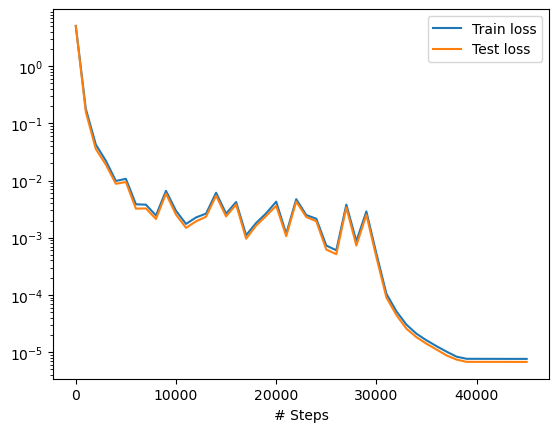

In [11]:
dde.utils.external.plot_loss_history(loss_history=losshistory)